In [128]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader, Subset
import torchvision.ops as ops
from model import FaceDetector
from yoloy_dataset import YoloDataset
from loss import Yolo_Loss
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [129]:
model = FaceDetector()

/Users/kuba/.vir-envs/TorchStudio/python/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kuba/.vir-envs/TorchStudio/python/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [130]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [131]:
PATH = '/Users/kuba/Documents/data/raw/single-face-tensors/train'
all_train_datasets = []

for file in sorted(os.listdir(PATH)):
    try:
        dataset = YoloDataset((PATH+"/"+file))
        all_train_datasets.append(dataset)
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")
        continue

combined = ConcatDataset(all_train_datasets)

In [68]:
optimizer = torch.optim.Adam(model.regression_head.parameters(), lr=0.00001)
criterion = Yolo_Loss()

/Users/kuba/.vir-envs/TorchStudio/python/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [69]:
len(combined)

17373

In [70]:
train_indices = list(range(3000))
dev_indices = list(range(3000, 3500))

# Create Subset datasets
train_dataset = Subset(combined, train_indices)
dev_dataset = Subset(combined, dev_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32)
dev_loader = DataLoader(dev_dataset, batch_size=128)

In [71]:
lossi = []
dev_lossi = []

In [72]:
device = 'mps'
model = model.to(device)

In [73]:
for epoch in tqdm(range(5)):
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    lossi.append(loss_total / len(train_loader))

    dev_loss_total = 0
    with torch.no_grad():
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device)
            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev)
            dev_loss_total += dev_loss.item()

    dev_lossi.append(dev_loss_total/ len(dev_loader))




100%|██████████| 5/5 [03:25<00:00, 41.16s/it]


In [367]:
y_dev.shape

torch.Size([116, 7, 7, 5])

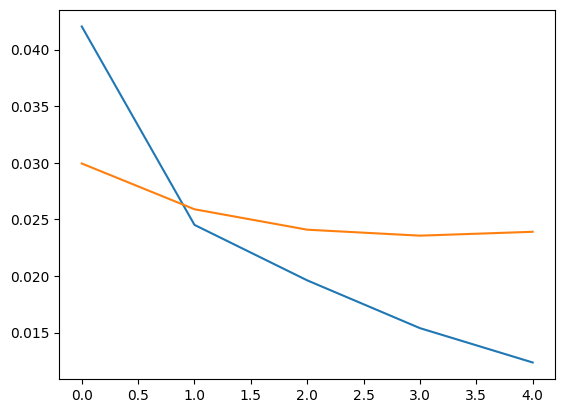

In [74]:
plt.plot(lossi)
plt.plot(dev_lossi)

In [75]:
dev_logits[0][..., 0].shape

torch.Size([])

In [76]:
dev_logits[0][..., 5]

tensor(0.0275, device='mps:0')

In [ ]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[0]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[1]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[2] / 2))
    half_height = int(len(im) * (bbox_pred[3] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()

In [78]:
y_batch[0][..., 0]

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], device='mps:0')

In [293]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def draw_bounding_boxes(image_tensor, tensor):
    """
    Draw bounding boxes on the image based on tensor predictions using matplotlib.
    
    Args:
        image_tensor: PyTorch tensor of shape (C, H, W)
        tensor: A tensor of shape (7, 7, 5) where each cell contains
               (confidence, x, y, width, height)
    """
    # Convert PyTorch tensor to numpy and rearrange dimensions
    if isinstance(image_tensor, torch.Tensor):
        # Handle PyTorch tensor - convert from (C,H,W) to (H,W,C)
        image = image_tensor.permute(1, 2, 0).numpy()
    else:
        # Already a numpy array
        image = image_tensor
    
    # Get image dimensions
    img_height, img_width = image.shape[:2]
    
    # Cell size in the original image
    cell_width = img_width / 7
    cell_height = img_height / 7
    
    # Create a figure
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    
    # Iterate through the grid
    for row in range(7):
        for col in range(7):
            # Get cell values
            confidence = tensor[row, col, 0]
            
            # Only process cells with confidence == 1
            if confidence >= 0.2:
                # Get bounding box parameters (relative to cell)
                x_rel = tensor[row, col, 1]
                y_rel = tensor[row, col, 2]
                width_rel = tensor[row, col, 3]
                height_rel = tensor[row, col, 4]
                
                # Convert to absolute image coordinates
                # x, y are center coordinates of the bounding box
                center_x = (col + x_rel) * cell_width
                center_y = (row + y_rel) * cell_height
                width = width_rel * cell_width
                height = height_rel * cell_height
                
                # Calculate corners
                xmin = center_x - width/2
                xmax = center_x + width/2
                ymin = center_y - height/2
                ymax = center_y + height/2
                
                # Plot center point
                plt.plot(center_x, center_y, 'ro')
                
                # Draw bounding box (horizontal lines)
                plt.hlines(ymin, xmin=xmin, xmax=xmax, colors='red')
                plt.hlines(ymax, xmin=xmin, xmax=xmax, colors='red')
                
                # Draw bounding box (vertical lines)
                plt.vlines(xmin, ymin=ymin, ymax=ymax, colors='red')
                plt.vlines(xmax, ymin=ymin, ymax=ymax, colors='red')
    
    plt.title('Detected Objects (Confidence = 1)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()  # Return the current figure if needed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0837073..2.3306088].


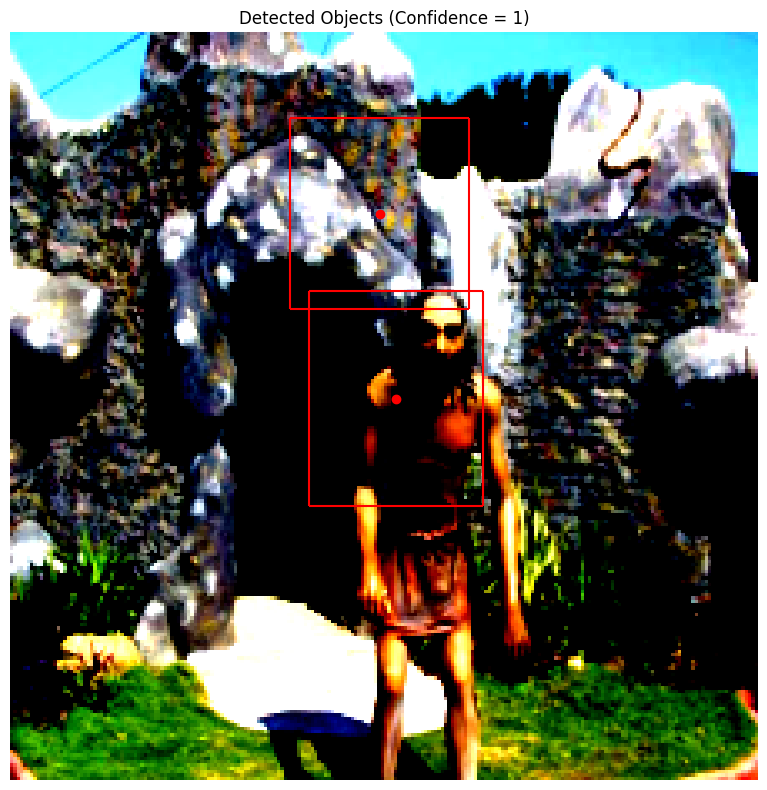

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [294]:
img_num = 6
prediction = dev_logits.view(-1, 7, 7, 10)
draw_bounding_boxes(X_dev[img_num].cpu(), prediction[img_num].detach().cpu())

In [81]:
prediction.shape

torch.Size([116, 7, 7, 10])

In [299]:
def yolo_label_to_cxcywh(label, img_size, S=7, absolute_pixl_values=False):
    #we assume imput size to be (S x S x 5)
    all_converted = []
    img_w, img_h = img_size
    cell_w, cell_h =  img_w/S, img_h/S
    for row in range(S):
        for col in range(S):
            #if its a bbox then confidace will be 1
            if label[row][col][0] == 1: 
                relative_x, relative_y = label[row][col][1], label[row][col][2]
                relative_w, relative_h = label[row][col][3], label[row][col][4]

                #these are in absolute pxl values not 0-1
                true_x = (col + relative_x) * cell_w
                true_y = (row + relative_y) * cell_h
                true_w = relative_w * cell_w
                true_h = relative_h * cell_h

                if absolute_pixl_values:
                    all_converted.append(torch.tensor([1, true_x, true_y, true_w, true_h]))
                else:
                #to make it 0-1
                    all_converted.append(torch.tensor([1, true_x/img_w, true_y/img_h, true_w/img_w, true_h/img_h]))
                    
    return torch.stack(all_converted)

In [353]:
def yolo_labels_to_xyxy(labels, S=7):
    #we assume imput size to be (BatchSize x S x S x 5)
    all_converted = []    
    for label in labels:
        batch_converted = []
        for row in range(S):
            for col in range(S):
                #if its a bbox then confidace will be 1
                if label[row][col][0] == 1: 
                    relative_x, relative_y = label[row][col][1], label[row][col][2]
                    relative_w, relative_h = label[row][col][3], label[row][col][4]

                    x_img = (col + relative_x) / S
                    y_img = (row + relative_y) / S
                    w_img = relative_w / S
                    h_img = relative_h / S
                    
                    x1 = x_img - w_img / 2
                    y1 = y_img - h_img / 2
                    x2 = x_img + w_img / 2
                    y2 = y_img + h_img / 2


                    batch_converted.append(torch.tensor([1, x1, y1, x2, y2]))
                        
        all_converted.append(torch.stack(batch_converted))
    return all_converted

In [351]:
y_batch[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.6775, 0.0422, 0.6275, 0.6956],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0

In [369]:
len(y_dev)

116

In [370]:
yolo_labels_to_xyxy(y_dev)[2]

tensor([[1.0000, 0.7829, 0.4568, 0.8517, 0.7143]])

In [371]:
len(yolo_labels_to_xyxy(y_dev))

116

In [368]:
y_batch.shape

torch.Size([24, 7, 7, 5])

In [343]:
def non_max_supp(preds, confidence_threshold = 0.2, iou_threshold=0.5, S=7, return_type='xywh'):
    batch_size = preds.shape[0]
    all_res = []


    for i in range(batch_size):
        pred = preds[i]

        all_scores = []
        all_boxes_xyxy = []
        all_boxes_xywh = []
        for row in range(S):
            for col in range(S):

                if pred[row, col][0] < confidence_threshold:
                    continue


                x_cell, y_cell, w_cell, h_cell = pred[row, col][1:5]
                
                x_img = (col + x_cell) / S
                y_img = (row + y_cell) / S
                w_img = w_cell / S
                h_img = h_cell / S
                
                x1 = x_img - w_img / 2
                y1 = y_img - h_img / 2
                x2 = x_img + w_img / 2
                y2 = y_img + h_img / 2

                all_scores.append(pred[row, col][0])
                all_boxes_xyxy.append(torch.tensor((x1,y1,x2,y2))) #for the nms calculation
                all_boxes_xywh.append(torch.tensor((x_img,y_img,w_img,h_img))) #for we will use to plot easy later

        #if no prediction has highenough confidace then we get rid of it
        if len(all_boxes_xyxy) == 0:
            all_res.append(torch.tensor([]))
            continue

        #here we get the idx of the valid boxes after non max suppreshion
        res = ops.nms(torch.stack(all_boxes_xyxy), torch.stack(all_scores), iou_threshold=iou_threshold)
        # for each of the idx we combine now with confidacne  
        if return_type == 'xywh':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xywh[idx][:])) for idx in res]
        elif return_type == 'xyxy':
            keep_boxes = [ torch.cat((all_scores[idx].unsqueeze(0), all_boxes_xyxy[idx][:])) for idx in res]
        #we append to the total preds list for each batch
        all_res.append(torch.stack(keep_boxes))
        
    return all_res


            

In [ ]:
res  = non_max_supp(prediction.detach().cpu(), return_type='xyxy')

In [332]:
def plot_post_non_max(img, preds, preds_type='cx,cy,w,h', labels=[], labels_type='cx,cy,w,h'):
    img = img.permute(1, 2, 0) #to go from (3 x W x H) to (W x H x 3)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    img_w, img_h = img.shape[:2]

    def plot_cxcywh_style(labels, img_w, img_h, color, marker='ro', show_confidance=False):
         for label in labels:
            confidance, center_x, center_y, width, height = label
            center_x, center_y, width, height = int(center_x * img_w), int(center_y * img_h), int(width * img_w), int(height * img_h)
            xmin = center_x - width/2
            xmax = center_x + width/2
            ymin = center_y - height/2
            ymax = center_y + height/2
            
            #  center and text
            if show_confidance:
                plt.text(center_x, center_y, f"{confidance.item():.3f}", bbox=dict(facecolor='white', alpha=0.35, boxstyle='round'), fontsize=8)
            plt.plot(center_x, center_y, marker)

            
            # (horizontal lines)
            plt.hlines(ymin, xmin=xmin, xmax=xmax, colors=color)
            plt.hlines(ymax, xmin=xmin, xmax=xmax, colors=color)
            
            # (vertical lines)
            plt.vlines(xmin, ymin=ymin, ymax=ymax, colors=color)
            plt.vlines(xmax, ymin=ymin, ymax=ymax, colors=color)
         

    if preds_type == 'cx,cy,w,h':
        plot_cxcywh_style(preds, img_w, img_h, 'red', 'ro', True)

    if len(labels) != 0 and labels_type == 'cx,cy,w,h':
        plot_cxcywh_style(labels, img_w, img_h, 'green', 'g1')
    
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0916114..2.4681716].


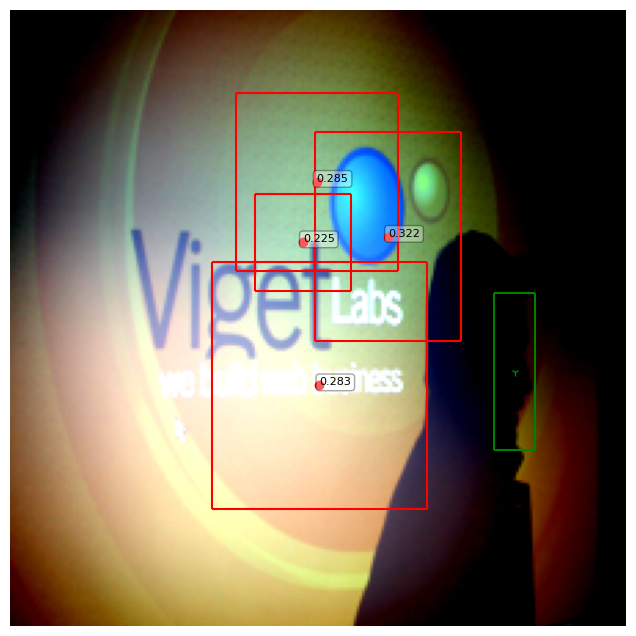

In [334]:
idx = 0
plot_post_non_max(X_dev[idx].cpu(), res[idx], labels=yolo_label_to_cxcywh(y_dev[idx], (224,224)))

In [384]:
y_dev_xyxy = yolo_labels_to_xyxy(y_dev)

In [ ]:
#map 
import numpy as np
import torchvision.ops as ops


def mAP(preds, labels, iou_start=0.5, iou_stop=0.95, iou_step=0.05):
    #expected shape for preds is (BatchSize x num_preds x 5)
    #expected shape for lables is (BatchSize x num_true_lables x 5)

    mAPs = [] #for each iou threshhold

    for iou in np.arange(start=iou_start, stop=iou_stop + iou_step/2, step=iou_step):
        for img_idx in range(len(preds)):
            true_pos_cnt = 0
            false_pos_cnt = 0
            ious = ops.box_iou(preds[img_idx][..., 1:5], labels[img_idx][..., 1:5])
            for row in ious:
                if torch.gt(row, iou):
                    true_pos_cnt += 1 
                else:
                    false_pos_cnt += 1

            img_precision = true_pos_cnt / (true_pos_cnt  + false_pos_cnt)
            img_recall = true_pos_cnt / (labels[img_idx].shape[0]) #divide by total num of true lables (TP + FN)
            print('p: ',img_precision)  
            print('r: ',img_recall)          





In [435]:
mAP(non_max_supp(prediction.detach().cpu(), return_type='xyxy'), y_dev_xyxy) #, iou_start=0.1, iou_stop=0.5)

p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.25
r:  1.0
p:  0.25
r:  1.0
p:  0.25
r:  1.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  1.0
r:  1.0
p:  1.0
r:  1.0
p:  1.0
r:  1.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.3333333333333333
r:  1.0
p:  0.3333333333333333
r:  1.0
p:  0.3333333333333333
r:  1.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0
r:  0.0
p:  0.0


In [ ]:
X_me00 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_side.pt')
X_me01 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_straighton.pt')
X_me02 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun_hand.pt')
X_me03 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun.pt')

me_full = torch.stack((X_me00,X_me01, X_me02, X_me03))

In [ ]:
me_full.shape


torch.Size([4, 3, 224, 224])

In [ ]:
img_num = 3
model_cpu = model.cpu()
logits = (model(me_full[img_num].unsqueeze(dim=0))).squeeze()
prediction = logits.view(-1, 7, 7, 10)
draw_bounding_boxes(me_full[img_num].cpu(), prediction[0].detach().cpu())


NameError: name 'me_full' is not defined